In [17]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [18]:
pts = np.loadtxt('incomes.txt')

In [5]:
pts

array([  53711.54439888,   99731.23334901,   84773.60541676,
         75184.025931  ,   73390.9559334 ,   77276.56474964,
         82597.32702898,   76098.11372822,   91850.97696668,
         71750.0904012 ,   78839.14719934,   76488.842497  ,
         98425.21508839,   89179.46995662,   69270.14146077,
         98745.58813476,   99678.12106606,  130562.89791757,
         96611.47162489,  107722.74557525,   89815.6930569 ,
         64096.00766797,  100953.33883423,  139079.35154872,
         56620.60756267,   93887.32671771,   54443.1018241 ,
         72214.43571941,   85334.16381855,   78259.71280733,
         83023.40314506,   88219.63714926,   87329.86039444,
         89740.87145837,   71486.02524282,   55951.62544771,
         66967.80460396,   85265.54454384,  126226.62999114,
        110291.25329238,   81804.83284175,   72162.4456693 ,
         68229.92749973,   86750.35322317,  118823.56074404,
        108877.93206918,   64915.4289308 ,  100934.6283851 ,
         64519.54919916,

<IPython.core.display.Javascript object>


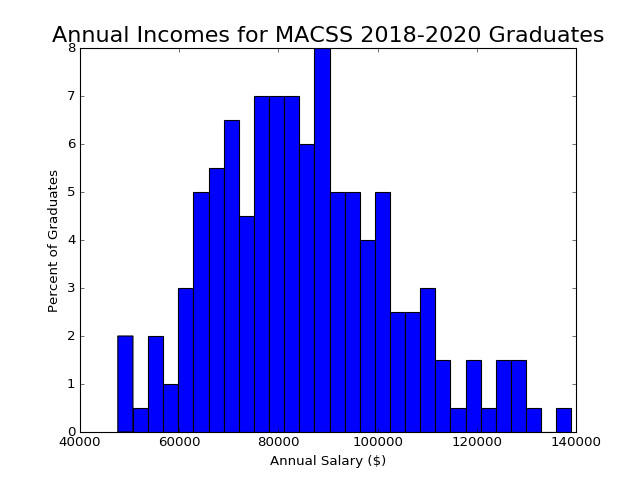

In [13]:
%matplotlib notebook

#count, bins, ignored = plt.hist(pts, 30, normed = True)

weights = (1 / pts.shape[0]) * np.ones_like(pts) * 100
n, bin_cuts, patches = plt.hist(pts, 30, weights=weights)

plt.title('Annual Incomes for MACSS 2018-2020 Graduates', fontsize=20)
plt.xlabel('Annual Salary ($)')
plt.ylabel('Percent of Graduates')


<IPython.core.display.Javascript object>


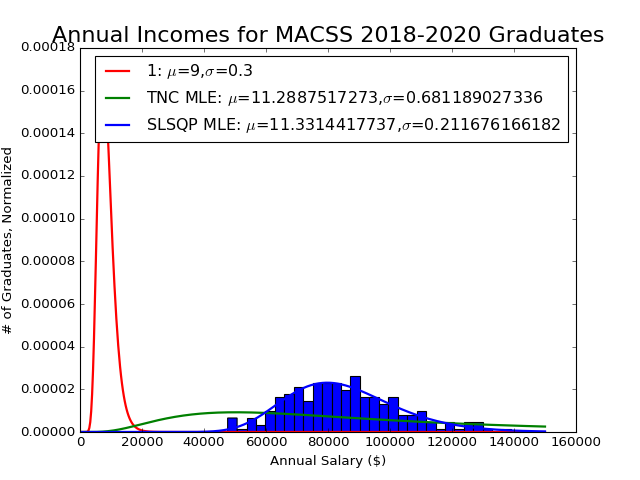

In [38]:
count, bins, ignored = plt.hist(pts, 30, normed = True)

plt.title('Annual Incomes for MACSS 2018-2020 Graduates', fontsize=20)
plt.xlabel('Annual Salary ($)')
plt.ylabel('# of Graduates, Normalized')

In [39]:
def lognorm_pdf(xvals, mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the lognormal pdf with mean mu and standard
    deviation sigma. If the cutoff is given, then the PDF values are
    inflated upward to reflect the zero probability on values above the
    cutoff. If there is no cutoff given, this function does the same
    thing as sp.stats.lognorm.pdf(x, loc=mu, scale=exp(mu), s = sigma).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar 
    pdf_vals = (N,) vector, lognormal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
    if cutoff == 'None':
        prob_notcut = 1.0
    else:
        prob_notcut = sts.norm.cdf(cutoff, loc=mu, scale=sigma)
        
    pdf_vals = ((1/(sigma * xvals * np.sqrt(2 * np.pi)) * 
                np.exp( -(np.log(xvals) - mu)**2 / (2 * sigma**2))) / 
                prob_notcut)
    
    return pdf_vals

dist_pts = np.linspace(0, 150000, 500)
mu_init = 9
sig_init = 0.3
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_init, sig_init, 'None'),
         linewidth=2, color='r', label='1: $\mu$=9,$\sigma$=0.3')
plt.legend(loc='upper right')

mu_MLE_1 = 11.2887517273
sig_MLE_1 = 0.681189027336
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_MLE_1, sig_MLE_1, 'None'), 
         linewidth=2, color='g', label='TNC MLE: $\mu$=11.2887517273,$\sigma$=0.681189027336')
plt.legend(loc='upper right')

mu_MLE_2 = 11.3314417737
sig_MLE_2 = 0.211676166182
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_MLE_2, sig_MLE_2, 'None'), 
         linewidth=2, color='b', label='SLSQP MLE: $\mu$=11.3314417737,$\sigma$=0.211676166182')
plt.legend(loc='upper right')

In [22]:
def log_lik_norm(xvals, mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    Compute the log likelihood function for data xvals given normal
    distribution parameters mu and sigma.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    pdf_vals    = (N,) vector, normal PDF values for mu and sigma
                  corresponding to xvals data
    ln_pdf_vals = (N,) vector, natural logarithm of normal PDF values
                  for mu and sigma corresponding to xvals data
    log_lik_val = scalar, value of the log likelihood function
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: log_lik_val
    --------------------------------------------------------------------
    '''
    pdf_vals = lognorm_pdf(xvals, mu, sigma, cutoff)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

print('Log-likelihood: ', log_lik_norm(pts, mu_init, sig_init, 'None'))

Log-likelihood:  -8298.63695601


In [23]:
def crit(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 2 tuple, (xvals, cutoff)
    xvals  = (N,) vector, values of the normally distributed random
             variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        log_lik_norm()
    
    OBJECTS CREATED WITHIN FUNCTION:
    log_lik_val = scalar, value of the log likelihood function
    neg_log_lik_val = scalar, negative of log_lik_val
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: neg_log_lik_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cutoff = args
    log_lik_val = log_lik_norm(xvals, mu, sigma, cutoff)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [24]:
import scipy.optimize as opt

mu_init = 9
sig_init = 0.3
params_init = np.array([mu_init, sig_init])
mle_args = (pts, 'None')
results = opt.minimize(crit, params_init, args=(mle_args), method = 'SLSQP')
mu_MLE, sig_MLE = results.x
print('mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)

mu_MLE= 11.3314417737  sig_MLE= 0.211676166182


In [25]:
results

     fun: 2239.534744013748
     jac: array([ 0.00646973,  0.01416016,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 148
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([ 11.33144177,   0.21167617])

In [26]:
import scipy.optimize as opt

mu_init = 9
sig_init = 0.3
params_init = np.array([mu_init, sig_init])
mle_args = (pts, 'None')
results = opt.minimize(crit, params_init, args=(mle_args), method = 'TNC')
mu_MLE, sig_MLE = results.x
print('mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)

mu_MLE= 11.2887517273  sig_MLE= 0.681189027336


In [27]:
results

     fun: 2383.3415201734488
     jac: array([ -18.39944161,  264.10052669])
 message: 'Linear search failed'
    nfev: 75
     nit: 3
  status: 4
 success: False
       x: array([ 11.28875173,   0.68118903])

In [29]:
mu_init = 9
sig_init = 0.3
params_init = np.array([mu_init, sig_init])
mle_args = (pts, 'None')
results = opt.minimize(crit, params_init, args=(mle_args), method = 'L-BFGS-B')
mu_MLE, sig_MLE = results.x
print('mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)

mu_MLE= 11.933590497  sig_MLE= 0.842739209057


In [30]:
results

      fun: nan
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 169.56973923,  101.1887889 ])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 153
      nit: 8
   status: 2
  success: False
        x: array([ 11.9335905 ,   0.84273921])

In [34]:
hessian = results.hess_inv
hessian.todense()

array([[ 1.,  0.],
       [ 0.,  1.]])

In [40]:
mu_MLE = 11.3314417737 
sig_MLE = 0.211676166182

In [41]:
print('Log-likelihood init: ', log_lik_norm(pts, mu_init, sig_init, 'None'))
print('MLE log-likelihood: ', log_lik_norm(pts, mu_MLE, sig_MLE, 'None'))

Log-likelihood init:  -8298.63695601
MLE log-likelihood:  -2239.53474401


In [42]:
log_lik_h0 = log_lik_norm(pts, mu_init, sig_init, 'None')
log_lik_mle = log_lik_norm(pts, mu_MLE, sig_MLE, 'None')
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)


chi squared of H0 with 2 degrees of freedom p-value =  0.0


In [145]:
prob_100000 = 1 - sts.lognorm.cdf(100000, loc=mu_MLE, s=sig_MLE, scale=np.exp(mu_MLE))
print('Probability > 100,000 Annual Salary', prob_100000)

Probability > 100,000 Annual Salary 0.195769577084


In [146]:
prob_75000 = sts.lognorm.cdf(75000, loc=mu_MLE, s=sig_MLE, scale=np.exp(mu_MLE))
print('Probability of < 75000 Annual Salary', prob_75000)

Probability of < 75000 Annual Salary 0.307687486898


<IPython.core.display.Javascript object>


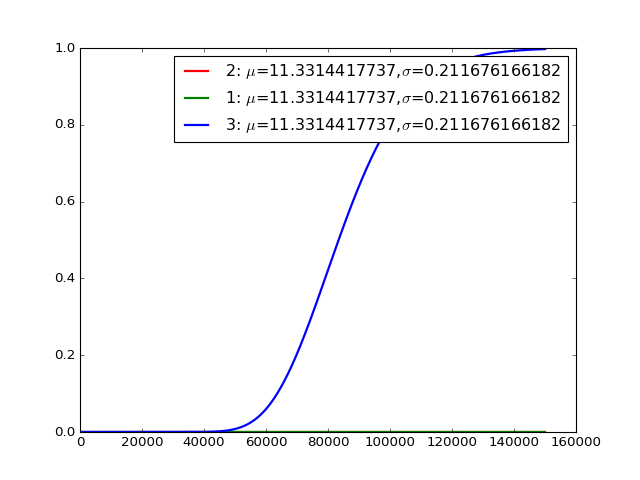

In [144]:


mu_MLE = 11.3314417737 
sig_MLE = 0.211676166182



plt.plot(dist_pts, sts.lognorm.pdf(dist_pts, loc=mu_MLE, s=sig_MLE, scale=np.exp(mu_MLE)), 
         linewidth=2, color='r', label='2: $\mu$=11.3314417737,$\sigma$=0.211676166182')
plt.legend(loc='upper right')

plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_MLE, sig_MLE, 'None'), 
         linewidth=2, color='g', label='1: $\mu$=11.3314417737,$\sigma$=0.211676166182')
plt.legend(loc='upper right')

plt.plot(dist_pts, sts.lognorm.cdf(dist_pts, loc=mu_MLE, s=sig_MLE, scale=np.exp(mu_MLE)), 
         linewidth=2, color='b', label='3: $\mu$=11.3314417737,$\sigma$=0.211676166182')
plt.legend(loc='upper right')